This is some of the ideas from https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94433#latest-561517. Solution is based on my own features as it wasn't described all of the features in discussion. Hence it scored 2.42174 on private score (instead of original solution 2.29978 

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import random as rand
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error 

import lightgbm as lgb
import xgboost as xgb

import os

from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam

from tsfresh.feature_extraction import feature_calculators

from tqdm import tqdm_notebook

import pywt

import librosa

from scipy.signal import find_peaks,peak_prominences
from scipy.stats import boxcox
%matplotlib inline

In [179]:
train_X = pd.read_csv("../../extracted_feat/train_x_55_cols.csv")
test_df = pd.read_csv("../../extracted_feat/test_55_cols.csv",index_col="Unnamed: 0")

In [180]:
train_y = pd.read_csv("../../extracted_feat/train_y_58.csv")

In [5]:
%time
train_df = pd.read_csv(os.path.join("../../input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


In [104]:

# def denoise_signal_simple(x, wavelet='db4', level=1):
#     coeff = pywt.wavedec(x, wavelet, mode="per")
#     #univeral threshold
#     uthresh = 10
#     coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
#     # Reconstruct the signal using the thresholded coefficients
#     return pywt.waverec(coeff, wavelet, mode='per')
# def create_features(seg_id,seg, X):
#     xc = seg["acoustic_data"]
    
#     x_roll_std = xc.rolling(1000).std().dropna().values
#     for i in [0.7,0.75,0.8,0.85,0.9,1.0,1.5,1.75,2.0,2.25,2.5]:
#         peaks, h = find_peaks(x_roll_std, height=[i], distance=2000)
#         if(h['peak_heights'].shape[0]>1):
#             X_tr.loc[segment, 'peaks_count_' + str(i)] = h['peak_heights'].shape[0]
#             X_tr.loc[segment, 'peaks_mean_' + str(i)] = h['peak_heights'].mean()
#             X_tr.loc[segment, 'peaks_std_' + str(i)] = h['peak_heights'].std()
#             X_tr.loc[segment, 'peaks_max_' + str(i)] = h['peak_heights'].max()
#             X_tr.loc[segment, 'peaks_min_' + str(i)] = h['peak_heights'].min()
#             #Peak prominences
#             prominences = peak_prominences(x_roll_std, peaks)[0]
#             contour_heights = x_roll_std[peaks] - prominences
#             X_tr.loc[segment, 'peaks_prom_mean_' + str(i)] = contour_heights.mean()
#             X_tr.loc[segment, 'peaks_prom_std_' + str(i)] = contour_heights.std()
#             X_tr.loc[segment, 'peaks_prom_max_' + str(i)] = contour_heights.max()
#             X_tr.loc[segment, 'peaks_prom_min_' + str(i)] = contour_heights.min()
#             #distance between peaks
#             X_tr.loc[segment, 'peaks_dist_mean_' + str(i)] = np.diff(peaks).mean()
#             X_tr.loc[segment, 'peaks_dist_std_' + str(i)] = np.diff(peaks).std()
#             X_tr.loc[segment, 'peaks_dist_max_' + str(i)] = np.diff(peaks).max()
#             X_tr.loc[segment, 'peaks_dist_min_' + str(i)] = np.diff(peaks).min()

In [105]:
def add_features_train(train_df,segments,train_X,train_y):
    for seg_id in tqdm_notebook(segments):
        shift = 0
        seg = train_df.iloc[seg_id*rows+shift:seg_id*rows+rows+shift]
        create_features(seg_id, seg,train_X)
        train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
        
        
def add_features_test(test_df):
    segment_names = [file for file in os.listdir("../../input") if file.startswith("seg")]
    for file in tqdm_notebook(segment_names):
        seg_id = file[:-4]
        segment = pd.read_csv(os.path.join("../../input",file),dtype={'acoustic_data': np.int16})
        create_features(seg_id,segment,test_df)

In [106]:
rows = 150000
segments = list(range(int((np.floor(train_df.shape[0]))/ rows)))
# segments = train_X.index.values
#Prepare empty frame
test_df = pd.DataFrame(dtype=np.float64)
train_X = pd.DataFrame(index=segments, dtype=np.float64)
train_y = pd.DataFrame(index=segments, dtype=np.float64, columns=['time_to_failure'])
# print("Number of segments: ", len(segments))
add_features_train(train_df,segments,train_X,train_y)
add_features_test(test_df)

In [181]:
scaler = StandardScaler()
scaler.fit(train_X)
train_X_scaled = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

In [182]:
eq = (train_y["time_to_failure"].diff() > 0.5)
eq_groups_data = pd.DataFrame(index=train_y.index)
eq_groups_data["earthquake"] = 0 
eq_groups_data.loc[eq,"earthquake"] = 1
eq_groups_data["earthquake"]=eq_groups_data["earthquake"].cumsum()


In [207]:
train_experiments = [
    [1,2,4,7,9,10,11,12,14],[1,2,4,7,8,9,10,11,14],[1,2,4,7,10,11,14],[1,3,7,10,11,14]
                    ]
subtrain_X = train_X_scaled[eq_groups_data["earthquake"].isin(train_experiments[0])].reset_index(drop=True)
# sns.distplot(subtrain_X["rollingMean200_num_peaks_10"])
# sns.distplot(test_scaled["rollingMean200_num_peaks_10"])

In [185]:
# sns.distplot(subtrain_X['peak_duration_mean'])
# sns.distplot(test_scaled['peak_duration_mean'])


In [205]:
def train_lgb(X_val,y_val,X_train,y_train,params):
    model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
    model.fit(X_train,y_train,
                  eval_set=[(X_val,y_val),(X_train,y_train)], 
                  verbose=5000,
                  early_stopping_rounds=1000)
    return model

def train_xgb(X_val,y_val,X_train,y_train,xgb_params):
    
    model = xgb.XGBRegressor(params=xgb_params)
    model.fit(X_train,y_train,
              eval_set=[(X_val,y_val),(X_train,y_train)], 
              verbose=5000,eval_metric='mae',
              early_stopping_rounds=1000)
    
    best_iteration = model.get_booster().best_ntree_limit
    return model

def seq_model(train_shape):
    model = Sequential()
    model.add(Dense(8,input_shape = (train_shape,),activation = 'relu'))

    model.add(Dropout(0.3))
#     model.add(Dense(16,activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(1))
    
    model.compile(loss = 'mae',optimizer = 'adam')
    return model

def train_nn(X_val,y_val,X_train,y_train):
    
    model = seq_model(X_train.shape[1])
    mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', 
                               save_best_only=True,
                               monitor='val_loss',
                               mode='min',verbose=1)
    model.fit(X_train,y_train,
              validation_data=(X_val,y_val), 
              verbose=-1,epochs=50,callbacks=[mcp_save])
    model.load_weights(filepath = '.mdl_wtsPL.hdf5')
    
    return model

In [206]:
folds = KFold(n_splits=3,shuffle=True,random_state=1)

xgb_params = {'eta': 0.01,
              'max_depth': 6,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'colsample_bylevel': 0.8,
              'colsample_bynode': 0.8,
              'lambda': 0.1,
              'alpha' : 0.1,

              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4
             }
lgb_params = {'num_leaves': 4,
          'min_data_in_leaf': 5,
          'objective':'fair',
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          'boost_from_average': True,
          "feature_fraction": 0.9,
          "bagging_freq": 1,
          "bagging_fraction": 0.5,
          "bagging_seed": 0,
          "metric": 'mae',
          "verbosity": -1,
          'max_bin': 500,
          'reg_alpha': 0,
          'reg_lambda': 0,
          'seed': 0
         }


In [208]:
predictions = pd.DataFrame(0,index=test_scaled.index,columns=["lgb0","nn0","xgb0"])
oof = pd.DataFrame(0,index=list(range(0,subtrain_X.shape[0])),columns=["lgb0","nn0","xgb0"])

feats = test_scaled.columns.values
for exp_no,exp in enumerate(train_experiments):
    print("train_experiment {}".format(exp))
    mask = eq_groups_data["earthquake"].isin(exp)
    subtrain_X = train_X_scaled[mask]
    subtrain_y = train_y[mask]
    
    predictors = ["lgb"+str(exp_no),"nn"+str(exp_no),"xgb"+str(exp_no)]
    for p in predictors:
        predictions[p] = 0.0
    for train_idx,val_idx in folds.split(subtrain_X,subtrain_y):
        X_train,y_train = subtrain_X.iloc[train_idx],subtrain_y.iloc[train_idx]
        X_val,y_val = subtrain_X.iloc[val_idx],subtrain_y.iloc[val_idx]
        
        model_lgb = train_lgb(X_val,y_val,X_train,y_train,lgb_params)
        
        oof.loc[val_idx,predictors[0]] = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration_)
        predictions[predictors[0]] += model_lgb.predict(test_scaled[feats], num_iteration=model_lgb.best_iteration_)
        
        model_xgb = train_xgb(X_val,y_val,X_train,y_train,xgb_params)
        best_iteration = model_xgb.get_booster().best_ntree_limit
        oof.loc[val_idx,predictors[1]] = model_xgb.predict(X_val, ntree_limit=best_iteration)
        predictions[predictors[1]] += model_xgb.predict(test_scaled[feats], ntree_limit=best_iteration)
        
        model_nn = train_nn(X_val,y_val,X_train,y_train)
        oof.loc[val_idx,predictors[2]] = model_nn.predict(X_val).reshape(len(X_val),)
        predictions[predictors[2]] += model_nn.predict(test_scaled[feats]).reshape(len(test_scaled),)
        

train_experiment [1, 2, 4, 7, 9, 10, 11, 12, 14]
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[313]	training's l1: 1.6435	valid_0's l1: 1.78069
[13:29:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:5.33605	validation_1-mae:5.31015
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 1000 rounds.
[99]	validation_0-mae:1.81516	validation_1-mae:1.53938
Train on 1884 samples, validate on 943 samples
Epoch 1/50

Epoch 00001: val_loss improved from inf to 6.19131, saving model to .mdl_wtsPL.hdf5
Epoch 2/50

Epoch 00002: val_loss improved from 6.19131 to 5.92769, saving model to .mdl_wtsPL.hdf5
Epoch 3/50

Epoch 00003: val_loss improved from 5.92769 to 5.49363, saving model to .mdl_wtsPL.hdf5
Epoch 4/50

Epoch 00004: val_loss improved from 5.49363 to 5.072

In [214]:
sub = predictions/3
final = (0.2*(sub["lgb0"]*0.15+sub["xgb0"]*0.45 +sub["nn0"]*0.4)+
         0.2*(sub["xgb1"]*0.45 +sub["nn1"]*0.45)+
         0.4*(sub["lgb2"]*0.2+sub["xgb2"]*0.3 +sub["nn2"]*0.5)+
         0.2*(sub["lgb3"]*0+sub["xgb3"]*0.6 +sub["nn3"]*0.4)
         )
submission = pd.DataFrame(
    {"time_to_failure":final})
submission["seg_id"] = test_X.index

In [223]:
submission.to_csv("../../submissions/kfolds/top_solutions/6th-place-sol_part.csv",index=False)


In [222]:
submission.describe()

,time_to_failure
count,2624.000000
mean,7.033628
std,3.259274
min,-1.907682
25%,4.288298
50%,6.388711
75%,9.781707
max,15.053845


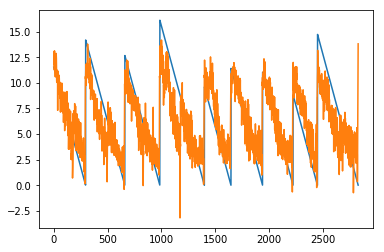